# DATA@KALAPATIDEVAKANTH

**Name - Devakanth Kalapati**

- ticket_data.csv: Containing a ticket history (one line => a ticket proposal
on tictactrip)
- cities.csv the cities served by tictactrip (link thanks to the o_city (origin_city) columns,
d_city (destination_city) of ticket_data)
- stations.csv the stations served by tictactrip (link via o_station, d_station of ticket_data)
- providers.csv info on the different providers (link via company of ticket_data)
A provider is a "sub-company". For example TGV and TER are two providers of VSC
(SNCF trips).
Your mission (if you accept it):
- extract interesting information such as min, average and max price, min / max / average duration by
path
- difference in average price and duration depending on train, bus and car depending on the distance from
route (0-200km, 201-800km, 800-2000km, 2000 + km)

Install and Import the necessary packages

In [511]:
import pandas as pd
import numpy as np
import geopandas as gpd
import descartes
from shapely.geometry import Point, polygon
import matplotlib.pyplot as plt
import os
from os.path import join

%matplotlib inline

<br>

Set Path

In [512]:
path = "C:/Users/dkalapati/Desktop/TicTacTrip"

<br>

Read the data

In [513]:
cities = pd.read_csv(join(path,"cities.csv"))
providers = pd.read_csv(join(path,"providers.csv"))
stations = pd.read_csv(join(path,"stations.csv"))
ticket_data = pd.read_csv(join(path,"ticket_data.csv"))

<br>

Let's try to understand the data first. So we check for null values and also see if we need to do any necessary changes to the data w.r.t datatype, merging etc

# ticket_data

In [514]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74168 entries, 0 to 74167
Data columns (total 12 columns):
id                 74168 non-null int64
company            74168 non-null int64
o_station          32727 non-null float64
d_station          32727 non-null float64
departure_ts       74168 non-null object
arrival_ts         74168 non-null object
price_in_cents     74168 non-null int64
search_ts          74168 non-null object
middle_stations    32727 non-null object
other_companies    32727 non-null object
o_city             74168 non-null int64
d_city             74168 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 6.8+ MB


In [515]:
ticket_data

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542
...,...,...,...,...,...,...,...,...,...,...,...,...
74163,6869182,13,279.0,10729.0,2017-10-27 02:30:00+00,2017-10-27 16:00:00+00,2590,2017-10-19 10:35:42.943+00,"{408,408}",{8371},628,562
74164,6869185,9,279.0,304.0,2017-10-27 07:00:00+00,2017-10-27 13:30:00+00,2700,2017-10-19 10:35:42.943+00,"{1105,1105}",{9},628,562
74165,6869187,8371,10642.0,304.0,2017-10-27 08:30:00+00,2017-10-27 15:15:00+00,3000,2017-10-19 10:35:42.943+00,"{1105,1105}",{9},628,562
74166,6869189,13,279.0,304.0,2017-10-27 13:25:00+00,2017-10-27 21:10:00+00,2880,2017-10-19 10:35:42.943+00,"{863,863}",{13},628,562


<br>

Here we have datetime columns which are not of the type datetime. In order to work with them later to get the duration between 2 different stations let's change the type to datetime

In [516]:
ticket_data[['departure_ts','arrival_ts','search_ts']] = ticket_data[['departure_ts','arrival_ts','search_ts']].apply(pd.to_datetime)

<br>

Duration between departure and arrival time. Let's use hours as our unit to measure the duration

In [517]:
ticket_data["duration_hours"] = ticket_data['arrival_ts'] - ticket_data['departure_ts']
ticket_data["duration_hours"] = ticket_data["duration_hours"]/np.timedelta64(1,'h')

<br>

rename column id to ticket_id to avoid confusion

In [518]:
ticket_data = ticket_data.rename(columns = {"id" : "ticket_id"})

<br>

Let's try to find which company has NaN for station and other columns

In [519]:
ticket_data[ticket_data["o_station"].isna()]["company"].unique()

array([8385], dtype=int64)

<br>

Looks like company 8385 wants to have it's information to be confidential. It did not provide info about the stations, middle stations and other companies.

In [520]:
ticket_data[ticket_data["company"] == 8385]

,ticket_id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,duration_hours
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,542,6.166667
5,6795030,8385,NaN,NaN,2017-10-06 05:30:00+00:00,2017-10-06 08:30:00+00:00,1800,2017-10-01 01:03:18.948000+00:00,NaN,NaN,628,453,3.000000
6,6795031,8385,NaN,NaN,2017-10-06 07:00:42+00:00,2017-10-06 09:30:42+00:00,2150,2017-10-01 01:03:18.948000+00:00,NaN,NaN,628,453,2.500000
7,6795032,8385,NaN,NaN,2017-10-06 07:10:00+00:00,2017-10-06 09:40:00+00:00,1700,2017-10-01 01:03:18.948000+00:00,NaN,NaN,628,453,2.500000
8,6795033,8385,NaN,NaN,2017-10-06 10:00:00+00:00,2017-10-06 12:50:00+00:00,1700,2017-10-01 01:03:18.948000+00:00,NaN,NaN,628,453,2.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74140,6869165,8385,NaN,NaN,2017-10-27 18:30:00+00:00,2017-10-27 22:50:00+00:00,2900,2017-10-19 10:35:31.269000+00:00,NaN,NaN,628,562,4.333333
74141,6869166,8385,NaN,NaN,2017-10-27 18:30:00+00:00,2017-10-27 23:10:00+00:00,3000,2017-10-19 10:35:31.269000+00:00,NaN,NaN,628,562,4.666667
74142,6869167,8385,NaN,NaN,2017-10-27 19:10:00+00:00,2017-10-27 23:00:00+00:00,2650,2017-10-19 10:35:31.269000+00:00,NaN,NaN,628,562,3.833333
74143,6869168,8385,NaN,NaN,2017-10-27 21:20:00+00:00,2017-10-28 01:10:00+00:00,2900,2017-10-19 10:35:31.269000+00:00,NaN,NaN,628,562,3.833333


<br>

Let's see the number of cities company 8385 has served so we can later get the stations based on city. 
Happens to be that there a lot of cities and each city has more than 1 station, which makes it impossible to get the stations.

In [522]:
ticket_data[ticket_data['company'] == 8385]['o_city'].unique()

array([  611,   628,   524,   424,  8398,   227,  1088,   843,    46,
         126,   453,   184,  7330,  9077,   560,   485,    21,   635,
          57,   504,   455,   697,   845,    33,   168,  5945,   200,
         109,    11,  9717,   562,  1061,   214,  5118,  7603,    28,
        8017,   328,   730,   192,   102,   727,    30,  8861,    52,
         239,   580,  8660,  8317,   847, 10033,   279,  5105,   107,
         848,  5459,   317,   438,   685,     6,  1064,   809,   152,
         657, 10006,   539,   857,   542,  8629,    23,  6780,  6135,
          54, 10719,  5489,   585,   185,   193,  6107,   277,   732,
         554,   872,  1532,   638,   132,  5115,   777,  7507,   488,
        9666,  7382,   541,   587,   719,  2245,  7284,   467,   714,
       11938,  6579,    15,   694, 11835,  5822,  2249,  9166, 10814,
         880, 12124,   428,  7561,   712,  8448,  6249, 10480,  6025,
        9148,    76,  7134,   213,   538,  7448, 11185,  8290,  6402,
         876,  8810,

<br>

Let's delete the records belonging to company 8385 for the purpose of our analysis

In [523]:
ticket_data = ticket_data[ticket_data["company"] != 8385]

# cities

In [524]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 6 columns):
id             8040 non-null int64
local_name     8040 non-null object
unique_name    8039 non-null object
latitude       8040 non-null float64
longitude      8040 non-null float64
population     369 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 377.0+ KB


<br>

We have NaN in the population column. We need not really worry about that because we aren't using that for our analysis

In [525]:
cities

,id,local_name,unique_name,latitude,longitude,population
0,5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
1,76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
2,81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
3,259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
4,11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN
...,...,...,...,...,...,...
8035,9964,"Saint-André-lez-Lille, Hauts-de-France, France",saint-andre-lez-lille,50.654250,3.047690,NaN
8036,10863,"Kiev, Шевченківський район, Ukraine",kiev,50.450100,30.523400,NaN
8037,11144,"Brighton, England, UK",brighton,50.822000,-0.137400,NaN
8038,11377,"Manises, Comunitat Valenciana, España",manises,39.493000,-0.462100,NaN


<br>

Let's plot the cities by utilizing the latitude and longitude provided

In [529]:
geometry = [Point(xy) for xy in zip(cities['longitude'], cities['latitude'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(cities, crs=crs, geometry=geometry)

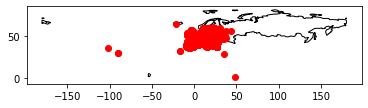

In [530]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to europe.
ax = world[world.continent == 'Europe'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

<br>

In order to get the region and country, let's split local name using str split function.  

In [531]:
# new data frame with split value columns 
split = cities["local_name"].str.split(",", n = 2, expand = True) 
  
# making separate city column from new data frame 
cities["city"]= split[0] 
  
# making separate region column from new data frame 
cities["region"]= split[1]

# making separate country column from new data frame 
cities["country"]= split[2]

#dropping local name
cities = cities.drop(columns = ["local_name"], axis=1)

# stations 

In [532]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11035 entries, 0 to 11034
Data columns (total 4 columns):
id             11035 non-null int64
unique_name    11035 non-null object
latitude       11035 non-null float64
longitude      11035 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 345.0+ KB


In [533]:
stations

,id,unique_name,latitude,longitude
0,1,Aalen (Stuttgarter Straße),48.835296,10.092956
1,2,Aéroport Bordeaux-Mérignac,44.830226,-0.700883
2,3,Aéroport CDG,49.009900,2.559310
3,4,Aéroport de Berlin-Schönefeld,52.389446,13.520345
4,5,Aéroport de Dresden,51.123604,13.764737
...,...,...,...,...
11030,11032,Porto Avda De Los Aliados,41.146922,-8.611122
11031,11033,Rom Ciampino Flughafen Piazzale Leonardo da Vinci,41.804102,12.597110
11032,11034,Sants,41.379892,2.139462
11033,11035,Vozilici D66,45.157136,14.164140


# providers

In [534]:
providers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 10 columns):
id                      227 non-null int64
company_id              227 non-null int64
provider_id             213 non-null object
name                    227 non-null object
fullname                227 non-null object
has_wifi                224 non-null object
has_plug                224 non-null object
has_adjustable_seats    224 non-null object
has_bicycle             224 non-null object
transport_type          227 non-null object
dtypes: int64(2), object(8)
memory usage: 17.9+ KB


<br>

Few NaNs present, since we are not using those columns for our analysis, we need not consider the scenario

In [535]:
providers

,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
0,9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
1,10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus
2,11,3,NaN,infobus,Infobus,False,False,False,False,bus
3,12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus
4,13,5,NaN,flixbus,Flixbus,True,False,False,False,bus
...,...,...,...,...,...,...,...,...,...,...
222,8384,10,16,thalys,Thalys,True,True,False,True,train
223,8385,11,NaN,bbc,Blablacar,False,False,False,False,carpooling
224,8387,30,NaN,vatry,Vatry,NaN,NaN,NaN,NaN,bus
225,8388,40,NaN,beauval,Beauval,NaN,NaN,NaN,NaN,bus


<br>

The name and full name values have different number of unique values. Let's find out the duplicate values which are repeated

In [536]:
for col in providers.columns:
    print(col,providers[col].nunique())

id 227
company_id 14
provider_id 213
name 227
fullname 225
has_wifi 2
has_plug 2
has_adjustable_seats 2
has_bicycle 2
transport_type 4


<br>

So happens to be that there is a possibility to have similar full names because it belongs to the same company_id

In [537]:
ids = providers["fullname"]
providers[ids.isin(ids[ids.duplicated()])]

,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
213,8375,10,0,trainter,TER,False,False,True,False,train
215,8377,10,2,corailintercite,Intercités,False,False,True,False,train
218,8380,10,5,train,TER,False,False,True,False,train
221,8383,10,9,corail,Intercités,False,False,True,False,train


<br>

Let's form a basetable with all the relevant data which we need for the given tasks. We start by merging the tables with the necessary columns and rename them with a proper naming convention for our understanding.

Cities

In [538]:
#Merge with cities to get the region, country, latitde and longitude for origin city

main = pd.merge(ticket_data, cities[["id","latitude","longitude","unique_name","region","country"]],  
                how='left', left_on='o_city', right_on='id').rename(columns = {"latitude" : "o_city_lat",
                "longitude" : "o_city_lon","unique_name" : "o_city_name","region" : "o_region", 
                "country" : "o_country"}).drop(columns = ["id"],axis = 1)

In [539]:
#Merge with cities to get the region, country, latitde and longitude for destination city

main = pd.merge(main, cities[["id","latitude","longitude","unique_name","region","country"]],  
                how='left', left_on='d_city', right_on='id').rename(columns = {"latitude" : "d_city_lat",
               "longitude" : "d_city_lon","unique_name" : "d_city_name", "region" : "d_region", 
                "country" : "d_country"}).drop(columns = ["id"],axis = 1)

Stations

In [540]:
#Merge with stations to get the latitde and longitude for origin station

main = pd.merge(main, stations[["id","latitude","longitude","unique_name"]],  
                how='left', left_on='o_station', right_on='id').rename(columns = {"latitude" : "o_stat_lat",
                "longitude" : "o_stat_lon", "unique_name" : "o_stat_name"}).drop(columns = ["id"],axis = 1)

In [541]:
#Merge with stations to get the latitde and longitude for destination station

main = pd.merge(main, stations[["id","latitude","longitude","unique_name"]],  
                how='left', left_on='d_station', right_on='id').rename(columns = {"latitude" : "d_stat_lat",
                "longitude" : "d_stat_lon", "unique_name" : "d_stat_name"}).drop(columns = ["id"],axis = 1)

Providers

In [542]:
main = pd.merge(main, providers[["id","name","transport_type"]],  
                how='left', left_on='company', right_on='id').rename(columns = {"name" : "company_name"}).drop(columns = ["id"],axis = 1)

<br>

We will be using the table main as our basetable for further analysis

In [543]:
main

,ticket_id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,...,d_region,d_country,o_stat_lat,o_stat_lon,o_stat_name,d_stat_lat,d_stat_lon,d_stat_name,company_name,transport_type
0,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{149,418}",{13},...,Occitanie,France,47.896911,1.854277,Avenue Georges Pompidou,43.583932,3.860233,Station Les Sabines,ouibus,bus
1,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",...,Occitanie,France,47.926740,1.906740,Les Aubrais,43.604900,3.880500,Montpellier,corailintercite,train
2,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",...,Occitanie,France,47.926740,1.906740,Les Aubrais,43.604900,3.880500,Montpellier,corailintercite,train
3,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},...,Occitanie,France,47.926740,1.906740,Les Aubrais,43.604900,3.880500,Montpellier,coraillunea,train
4,6795074,13,767.0,396.0,2017-10-06 05:25:00+00:00,2017-10-06 16:40:00+00:00,1990,2017-10-01 01:04:12.450000+00:00,"{932,932}",{13},...,Hauts-de-France,France,48.727660,2.264629,Massy-Palaiseau,50.638756,3.076675,Gare Lille-Europe,flixbus,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32722,6869182,13,279.0,10729.0,2017-10-27 02:30:00+00:00,2017-10-27 16:00:00+00:00,2590,2017-10-19 10:35:42.943000+00:00,"{408,408}",{8371},...,Pays-de-la-Loire,France,48.838424,2.382411,Gare de Bercy,47.212922,-1.551565,Nantes Halluchère - Route de Paris,flixbus,bus
32723,6869185,9,279.0,304.0,2017-10-27 07:00:00+00:00,2017-10-27 13:30:00+00:00,2700,2017-10-19 10:35:42.943000+00:00,"{1105,1105}",{9},...,Pays-de-la-Loire,France,48.838424,2.382411,Gare de Bercy,47.248785,-1.520898,Gare de Haluchère-Batignolles,ouibus,bus
32724,6869187,8371,10642.0,304.0,2017-10-27 08:30:00+00:00,2017-10-27 15:15:00+00:00,3000,2017-10-19 10:35:42.943000+00:00,"{1105,1105}",{9},...,Pays-de-la-Loire,France,48.865601,2.414588,Gare Routière Internationale de Paris-Gallieni...,47.248785,-1.520898,Gare de Haluchère-Batignolles,isilines,bus
32725,6869189,13,279.0,304.0,2017-10-27 13:25:00+00:00,2017-10-27 21:10:00+00:00,2880,2017-10-19 10:35:42.943000+00:00,"{863,863}",{13},...,Pays-de-la-Loire,France,48.838424,2.382411,Gare de Bercy,47.248785,-1.520898,Gare de Haluchère-Batignolles,flixbus,bus


<br>

Let's write a function to get the distance between stations and cities.

In [544]:
def distance(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)
    """
    
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


Let's use the distance function to get the distance between cities and stations

In [545]:
#for distance between cities
main['city_dist'] = \
    distance(main.o_city_lat, main.o_city_lon,
                 main.d_city_lat, main.d_city_lon)

#for distance between stations
main['station_dist'] = \
    distance(main.o_stat_lat, main.o_stat_lon,
                 main.d_stat_lat, main.d_stat_lon)

# Key Figures

Let's write a class with unicodes for various font formats

In [546]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

<br>

The max, min and average price in cents and time in hours for different transport type w.r.t distance

In [547]:
for i,j in zip(list([0,200,800,2000]),list([200,800,2000,None])):
    if j != None:
        print(color.BOLD + "Distance between :" + str(i) + " - " + str(j) + color.END)
        k = main[(main["station_dist"] > i) & (main["station_dist"] < j)]
        display(k.groupby("transport_type").agg({'price_in_cents': ('max','min','mean'), 'duration_hours' : ('max','min',"mean")}).reset_index())
        print("\n")
    else:
        print(color.BOLD + "Distance more than :" + str(i) + "\n" + color.END)
        k = main[main["station_dist"] > i]
        display(k.groupby("transport_type").agg({'price_in_cents': ('max','min','mean'), 'duration_hours' : ('max','min',"mean")}).reset_index())

Distance between :0 - 200


transport_type price_in_cents                   duration_hours            \
                            max  min         mean            max       min   
0            bus          22900  850  2109.564581         317.75  1.083333   
1          train          25100  490  3597.305970          34.45  0.650000   

              
        mean  
0  10.790857  
1   4.361138



Distance between :200 - 800


transport_type price_in_cents                    duration_hours            \
                            max   min         mean            max       min   
0            bus          22480  1000  3533.660382         492.85  2.483333   
1          train          38550  1400  9189.725709          48.45  1.483333   

              
        mean  
0  15.107998  
1   7.737257



Distance between :800 - 2000


transport_type price_in_cents                     duration_hours             \
                            max   min          mean            max        min   
0            bus          17400  2290   6955.783514     353.000000  12.250000   
1          train          37550  4550  15680.126183      40.616667   4.516667   

              
        mean  
0  27.546437  
1  12.217350



Distance more than :2000



Empty DataFrame
Columns: [(transport_type, ), (price_in_cents, max), (price_in_cents, min), (price_in_cents, mean), (duration_hours, max), (duration_hours, min), (duration_hours, mean)]
Index: []

<br>

The distance served by each company and the type of transport

In [548]:
main.groupby(["company_name","transport_type"]).agg({'station_dist' : ('max','min','mean')}).reset_index()

company_name transport_type station_dist                          
                                            max          min         mean
0   corailintercite          train  1007.369803    41.073595   361.438542
1       coraillunea          train   911.799562   493.396861   740.719490
2           deinbus            bus   656.441139   261.997396   406.942154
3         eurolines            bus  1749.195485    81.469504   617.120717
4       eurolinesUK            bus  1036.038679   410.941991   727.561444
5          eurostar          train  1038.932519    83.212614   401.277272
6        expressbus            bus  1865.468702  1865.468702  1865.468702
7           flixbus            bus  1749.195485    27.826373   481.342682
8          globtour            bus   322.300487   322.300487   322.300487
9          isilines            bus  1752.371650    60.405649   467.952313
10  nationalExpress            bus  1254.707517    56.601798   314.609917
11          navette            bus   663.833419    26.923590   282.241450
12   navettedeVatry            bus   309.432592    38.703414   136.694657
13           ouibus            bus  1753.861309    30.512981   450.528109
14    studentAgency            bus   531.315100   124.482565   378.097122
15              tgv          train  1013.014162    36.861105   444.724580
16           thalys          train   831.782036    83.212614   436.431913
17            train          train   841.595148    16.570475   360.393595
18            vatry            bus   278.150419    38.479551   144.956570

<br>

The longest distance is served by expressbus by bus from bucharest to paris

In [549]:
print(color.BOLD + "Longest Distance" + color.END)
main[main["station_dist"] == max(main["station_dist"])][["company_name","transport_type","price_in_cents","o_stat_name","d_stat_name","o_city_name","d_city_name","o_country","d_country","station_dist"]]

Longest Distance


,company_name,transport_type,price_in_cents,o_stat_name,d_stat_name,o_city_name,d_city_name,o_country,d_country,station_dist
19665,expressbus,bus,16395,Bucuresti,Gare de Bercy,bucharest,paris,România,France,1865.468702


<br>

The shortest distance is served by train by train

In [550]:
print(color.BOLD + "Shortest Distance" + color.END)
main[main["station_dist"] == min(main["station_dist"])][["company_name","transport_type","price_in_cents","o_stat_name","d_stat_name","o_city_name","d_city_name","o_country","station_dist"]]

Shortest Distance


,company_name,transport_type,price_in_cents,o_stat_name,d_stat_name,o_city_name,d_city_name,o_country,station_dist
29662,train,train,490,Nice Riquier,Roquebrune-Cap-Martin,nice,roquebrune-cap-martin,France,16.570475


<br>

max, min, average price and duration by path 

In [551]:
main.groupby(["o_stat_name","d_stat_name"]).agg({'price_in_cents' : ('max','min','mean'), 'duration_hours' : ('max','min','mean')}).reset_index()

o_stat_name  \
                                                   
0                       Aeroport Cdg2 Tgv Roissy   
1                                           Agen   
2                                           Agen   
3                                           Agen   
4                                Agen (Exit A62)   
...                                          ...   
2661  Zurich central station (Sihlquai car park)   
2662  Zurich central station (Sihlquai car park)   
2663                           parking Velodrome   
2664                           parking Velodrome   
2665                           parking Velodrome   

                                            d_stat_name price_in_cents        \
                                                                   max   min   
0                                                Cannes          13300  6600   
1                                 Gare SNCF Dijon Ville          13650  9860   
2                       Gare de Marseille Saint-Charles           8920  4950   
3                             Gare routière de Toulouse           2420  2420   
4     Gare Routière Internationale de Paris-Gallieni...           2800  2600   
...                                                 ...            ...   ...   
2661                           Gare de Liège-Guillemins           4190  4190   
2662                        Gare routière de Strasbourg           1780  1400   
2663                                Gare Bruxelles-Midi           4090  4090   
2664                             Gare de Bruxelles-Nord           3980  3980   
2665                            Gare routière de Berlin           5490  3800   

                   duration_hours                        
              mean            max        min       mean  
0      9022.222222       8.183333   6.516667   7.087037  
1     11755.000000      15.016667  12.400000  13.708333  
2      6510.000000       8.266667   5.600000   6.770000  
3      2420.000000       4.183333   4.183333   4.183333  
4      2666.666667      14.500000   9.666667  12.194444  
...            ...            ...        ...        ...  
2661   4190.000000      11.500000  11.500000  11.500000  
2662   1590.000000      10.583333   4.916667   7.000000  
2663   4090.000000      13.500000  13.500000  13.500000  
2664   3980.000000      14.750000  14.750000  14.750000  
2665   4692.500000      39.083333  15.250000  25.395833  

[2666 rows x 8 columns]

**There is scope for a lot of analysis. This is just a basic analysis.**